# Import 

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from numpy import pi
import numpy as np
from gemseo import to_pickle
from gemseo.disciplines.surrogate import SurrogateDiscipline
from lh2pac.utils import update_default_inputs
from numpy import array
from gemseo import from_pickle
from gemseo import to_pickle
import pandas as pd

configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [7]:
update_default_inputs(disciplines, {"slst": 100000, "n_pax":120, "area":108.0711016127496, "ar":14.80506792391749})
disciplines[0].io.input_grammar.defaults

{'area': 108.0711016127496, 'ar': 14.80506792391749, 'length': 37.0, 'aef': 1.0}

# Create design space

In [9]:
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from

design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)
design_space.add_variable('aef', lower_bound=0.99, upper_bound=1.03, value=1.0)
design_space.add_variable('cef', lower_bound=0.99, upper_bound=1.03, value=1.0)
design_space.add_variable('sef', lower_bound=0.99, upper_bound=1.03, value=1.0)

# Split train/test dataset

c'est les bon algos names ?

In [10]:
training_dataset = sample_disciplines(disciplines, design_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)
test_dataset = sample_disciplines(disciplines, design_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=20)

    INFO - 15:06:33: *** Start Sampling execution ***
    INFO - 15:06:33: Sampling
    INFO - 15:06:33:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:06:33:    MDO formulation: MDF
    INFO - 15:06:33: Running the algorithm OT_OPT_LHS:
    INFO - 15:06:33:    100%|██████████| 20/20 [00:00<00:00, 313.70 it/sec]
    INFO - 15:06:33: *** End Sampling execution (time: 0:00:00.069981) ***
    INFO - 15:06:33: *** Start Sampling execution ***
    INFO - 15:06:33: Sampling
    INFO - 15:06:33:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:06:33:    MDO formulation: MDF
    INFO - 15:06:33: Running the algorithm OT_MONTE_CARLO:
    INFO - 15:06:34:    100%|██████████| 20/20 [00:00<00:00, 330.01 it/sec]
    INFO - 15:06:34: *** End Sampling execution (time: 0:00:00.062849) ***


# Try different surrogate

 Testing surrogate: RBF_gaussian_5
 Testing surrogate: RBF_gaussian_4
 Testing surrogate: RBF_gaussian_2
 Testing surrogate: RBF_gaussian_mg
 Testing surrogate: Polynomial_deg2
 Testing surrogate: Polynomial_deg2

Résultats comparatifs :
                     fm  length    mtom    span    tofl    vapp      vz
Model                                                                  
RBF_gaussian_5   0.9805  0.9998  0.9588  0.9744  0.9193  0.9844  0.9290
RBF_gaussian_4   0.9803  0.9995  0.9610  0.9757  0.9181  0.9839  0.9301
RBF_gaussian_2   0.9744  0.9934  0.9716  0.9808  0.9036  0.9746  0.9360
RBF_gaussian_mg  0.9805  1.0000  0.9697  0.9739  0.9451  0.9828  0.9474
Polynomial_deg2  0.9804  0.9767  0.9073  0.9550  0.8035  0.9448  0.7878
Polynomial_deg2  0.9600  0.9292  0.8679  0.9256  0.7226  0.8871  0.6400


<Figure size 1200x600 with 0 Axes>

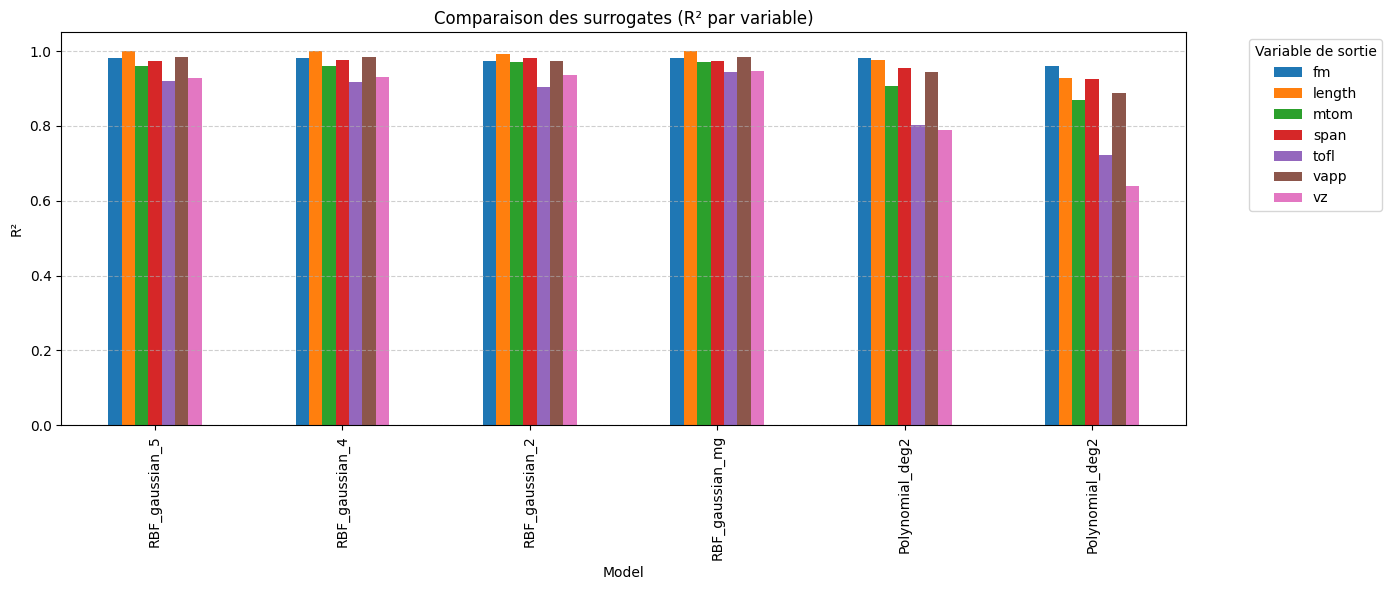

In [11]:
surrogate_configs = [
    {"name": "RBF_gaussian_5", "model": "RBFRegressor", "function": "gaussian", "epsilon": 5},
    {"name": "RBF_gaussian_4", "model": "RBFRegressor", "function": "gaussian", "epsilon": 4},
    {"name": "RBF_gaussian_2", "model": "RBFRegressor", "function": "gaussian", "epsilon": 2},
    {"name": "RBF_gaussian_mg", "model": "RBFRegressor", "function": "multiquadric", "epsilon": 5},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 2},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 3},
]

results = []

for config in surrogate_configs:
    name = config["name"]
    model_type = config["model"]
    kwargs = {k: v for k, v in config.items() if k not in ["name", "model"]}

    print(f" Testing surrogate: {name}")
    
    surrogate = SurrogateDiscipline(model_type, data=training_dataset, **kwargs)
    r2 = surrogate.get_error_measure("R2Measure")
    test_scores = r2.compute_test_measure(test_dataset, as_dict=True)
    
    flat_scores = {key: float(value) for key, value in test_scores.items()}
    flat_scores["Model"] = name
    results.append(flat_scores)

df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
print("\nRésultats comparatifs :")
print(df_results.round(4)
)
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(14, 6))
plt.title("Comparaison des surrogates (R² par variable)")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Variable de sortie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save best surrogate

In [15]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", epsilon = 5, data = training_dataset, function="multiquadric")

In [16]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.96001246]),
 'length': array([0.92916679]),
 'mtom': array([0.86794751]),
 'span': array([0.92564715]),
 'tofl': array([0.72256997]),
 'vapp': array([0.88710383]),
 'vz': array([0.64004129])}

In [17]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.0896333]),
 'length': array([0.02529237]),
 'mtom': array([623.17419777]),
 'span': array([1.33376472]),
 'tofl': array([90.20774445]),
 'vapp': array([0.83017623]),
 'vz': array([0.88346589])}

In [18]:
to_pickle(surrogate_discipline, "my_surrogate_3.pkl")